<a href="https://colab.research.google.com/github/lyeskhalil/mlbootcamp2022/blob/main/lab_4_1_convnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lyeskhalil/mlbootcamp2022/blob/main/lab_4_1_convnets.ipynb)

# UofT FASE ML Bootcamp
#### Wednesday June 16, 2022
#### Convolutional Neural Network - Lab 1, Day 3 
#### Teaching team: Elias Khalil, Alex Olson, Rahul Patel, and Jake Mosseri
##### Lab author: Rahul Patel, rm.patel@mail.utoronto.ca
##### Adapted from: [Transfer learning for computer vision tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#transfer-learning-for-computer-vision-tutorial)


In this lab, we will learn about convolution neural networks (CNN) and how to do transfer learning using a pretrained CNN for an image classification task.

In [1]:
# Basic imports
import os
import copy

import numpy as np
import matplotlib.pyplot as plt

import time

from pathlib import Path
from os import system

### Convolution Neural Networks

A CNN is a type of model that allows us to efficiently extract features from image data to perform various downstream tasks like image classification, segmentation etc. CNNs learn "filters" that recognize patterns, and can then look for the presence of these patterns anywhere in the image.

As we move to working with more complex models, we need ever increasing amounts of training data. This poses a challenge when we are dealing with a highly specific task that may not have a lot of data available. Luckily, we aren't totally stuck here. We can take advantage of transfer learning.

In a nutshell, transfer learning refers to when we take a model trained on a more general task, and then re-train part of that model to deal with our more specific problem. For example, in this lab we will take a convolutional network which is trained to recognize a wide array of objects, and re-train part of it to distinguish specific insects. The hope is that the broader task has allowed the model to learn useful patterns to recognize, and when re-training on our specific problem it can use what it has learned to solve the task.

These two major transfer learning scenarios look as follows:

- **ConvNet as fixed feature extractor**: Here, we will freeze the weights (i.e. not learn any further) for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained. In this way, the parts of the model which deal with the image itself will stay the same, and only the final decision-making part which predicts the subject of the image will be changed.

- **Finetuning the ConvNet**: Here, instead of random initialization, we take the existing trained network and allow the model to change any part of it during re-training. In this way, patterns that may be useful for e.g. identifying a boat can be discarded by the model and replaced with patterns that are useful for identifying more task-relevant elements.

In [11]:
# Necessary imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms

cudnn.benchmark = True
plt.ion()  

### Load Data

We will use `torchvision` and `torch.utils.data` packages for loading the data.

The problem we’re going to solve today is to train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. If we train a model from scratch using this data, we will likely find that we just don't have enough data to make good predictions. But we can take advantage of models that have already been trained on tens of thousands of images across many different categories so that the model already knows how to identify important features of an image.

In [25]:
# Download the dataset from Pytorch's website (unless it is already downloaded!)
if not Path('hymenoptera_data.zip').exists(): 
  system('wget https://download.pytorch.org/tutorial/hymenoptera_data.zip')

if not Path('hymenoptera_data').exists():
  system('unzip hymenoptera_data.zip')

# The images we have downloaded are not in the exact format we need,
# so we'll adjust them here. While we're at it, we also make some random
# transformations to the training data, so that it's like we have extra samples
# (a bee that is upside down should still be recognized as a bee!)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

# Determine whether a GPU is available for training or not.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Training on {device}')

Training on cuda:0


### Visualize a few images

Let’s visualize a few training images so as to understand the data augmentations. 

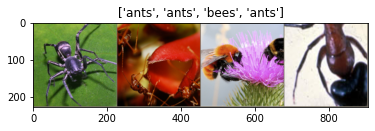

In [29]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Training loop

In the previous labs, we picked a single learning rate to use during training.
We can be more sophisticated, however. PyTorch (and other popular ML libraries) are capable of changing ("scheduling") the learning rate automatically over the course of training. Generally, as the error improves we want to gradually reduce the learning rate - think of this as focusing on smaller and smaller problems in the prediction as we get closer to an optimal solution.

The code below sets up how our model is going to train. This includes a learning rate scheduler, and all the stages of the training are commented. Try to read through and see if you understand what's going on.

In [30]:
# Training loop

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time() #We are going to track how long training took - save the current time.

    best_model_wts = copy.deepcopy(model.state_dict()) #Typically we try to save the best version of the model as we go - the final iteration might be slightly worse than one before it!
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device) #Send the data to the GPU
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step() #The scheduler sets our learning rate - this tells it to check if it's time to decrease the LR

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # If this epoch has the best performance so far, we save a copy of it
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visualizing the model predictions

Generic function to display predictions for a few images

In [31]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Before we try transfer learning, let's get a sense of what we are comparing against. We will start out by training a model _only_ on our ant and bee dataset.

We are going to use a pre-defined model, but specify that we don't want to use the weights associated with it - we'll make our own.

**YOUR TURN**:

- Load a ResNet18 model using `torchvision.models` _without_ pretrained weights: Follow the instructions [here](https://pytorch.org/vision/stable/models.html) to learn about constructing CNN models with standard architectures used in the literature. 

For example: For creating an AlexNet, the CNN architecture proposed by Geoff Hinton, Alex Krizhevsky and Ilya Sutskever that won the ImageNet competition in 2012, with pretrained weights we call:

`alexnet = torchvision.models.alexnet(pretrained=True)` 


In [35]:
model_conv = ## YOUR CODE HERE

In [37]:
model_conv = model_conv.to(device) #Move the model to our GPU

criterion = nn.CrossEntropyLoss() #Set up our loss function

#Set up stochastic gradient descent with a learning rate of 0.001
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.6579 Acc: 0.5738


KeyboardInterrupt: ignored

Make a note of the accuracy that this model got when only training using our small ant and bee dataset. Next, we are going to take the pre-trained model, and only re-train the final prediction step.

**YOUR TURN**:

- Freeze the weights of the pretrained ResNet18: By default, PyTorch expects to train the entire model. To determine whether a parameter can be tuned or not we can check their `required_grad` attribute - i.e, whether we are modifying it during gradient descent. If we set this to `False`, `PyTorch` will not optimize these weights on the `.backward()` call, and keep it the same as when we downloaded it.

Hint: `print(param.requires_grad)`

In [40]:
#Load ResNet18 but keep the pre-trained weights this time:
model_conv = ## YOUR CODE HERE

# Access all the parameters of the model
for param in model_conv.parameters():
    ## YOUR CODE HERE

In [42]:
#We are now only changing the parameters in the fully connected layers at the end
num_ftrs = model_conv.fc.in_features #Number of features in the fully connected layers
model_conv.fc = nn.Linear(num_ftrs, 2) #Overwrite the existing weights at the end with a blank, randomly initialized set

model_conv = model_conv.to(device) #Copy the model to our GPU

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer (model_conv.fc) are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001)

# Decay learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.6571 Acc: 0.6189
val Loss: 0.5490 Acc: 0.7190

Epoch 1/9
----------
train Loss: 0.5765 Acc: 0.7131
val Loss: 0.4666 Acc: 0.7778

Epoch 2/9
----------
train Loss: 0.5485 Acc: 0.7377
val Loss: 0.3752 Acc: 0.8824

Epoch 3/9
----------
train Loss: 0.5037 Acc: 0.7664
val Loss: 0.3303 Acc: 0.8954

Epoch 4/9
----------
train Loss: 0.4452 Acc: 0.8197
val Loss: 0.3172 Acc: 0.8954

Epoch 5/9
----------
train Loss: 0.4408 Acc: 0.7828
val Loss: 0.2732 Acc: 0.9150

Epoch 6/9
----------
train Loss: 0.4314 Acc: 0.8361
val Loss: 0.2646 Acc: 0.9346

Epoch 7/9
----------
train Loss: 0.4491 Acc: 0.7828
val Loss: 0.2607 Acc: 0.9346

Epoch 8/9
----------
train Loss: 0.4374 Acc: 0.7992
val Loss: 0.2577 Acc: 0.9346

Epoch 9/9
----------
train Loss: 0.4327 Acc: 0.8238
val Loss: 0.2573 Acc: 0.9281

Training complete in 0m 33s
Best val Acc: 0.934641


How did we do? Compare the validation accuracy even in the first few epochs to the final validation accuracy when we were training the entire model from scratch.

### Finetuning the ResNet18

This time, we are going to start with the pre-trained weights for the entire model, but during training we won't restrict what weights PyTorch can update.

Unlike before where we set some of the parameters to `requires_grad=False`, here we will do the opposite.

**YOUR TURN**:

- Finetune ResNet18: Modify the code below to make ResNet18 finetunable

In [44]:
model_conv = ##YOUR CODE HERE

# Access all the parameters of the model
for param in model_conv.parameters():
    ## YOUR CODE HERE

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.6450 Acc: 0.6189
val Loss: 0.5665 Acc: 0.7255

Epoch 1/9
----------
train Loss: 0.5865 Acc: 0.7049
val Loss: 0.4506 Acc: 0.7908

Epoch 2/9
----------
train Loss: 0.5059 Acc: 0.7664
val Loss: 0.3910 Acc: 0.8627

Epoch 3/9
----------
train Loss: 0.5070 Acc: 0.7377
val Loss: 0.3412 Acc: 0.9085

Epoch 4/9
----------
train Loss: 0.5026 Acc: 0.7336
val Loss: 0.3388 Acc: 0.8693

Epoch 5/9
----------
train Loss: 0.4263 Acc: 0.8115
val Loss: 0.2909 Acc: 0.9150

Epoch 6/9
----------
train Loss: 0.4611 Acc: 0.7746
val Loss: 0.2726 Acc: 0.9085

Epoch 7/9
----------
train Loss: 0.4320 Acc: 0.8156
val Loss: 0.2737 Acc: 0.9150

Epoch 8/9
----------
train Loss: 0.4353 Acc: 0.8033
val Loss: 0.2695 Acc: 0.9150

Epoch 9/9
----------
train Loss: 0.4335 Acc: 0.7910
val Loss: 0.2650 Acc: 0.9216

Training complete in 0m 35s
Best val Acc: 0.921569


**YOUR TURN**

Compare the three ways we trained the same model. Which performed best, out of our two approaches to transfer learning? Can you estimate why?

If you have time, try playing around with some of the hyper-parameters of the model, and see if you can improve performance further. Here are some directions to look in:

1. How many epochs should we train for?
2. How fast or slow should the learning rate be at the start? Should we change how quickly it reduces in the scheduler?
3. Our optimizer is stochastic gradient descent, but there are [more options](https://pytorch.org/docs/stable/optim.html) out there - try out some others.